In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import copy
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet, BayesianRidge,ARDRegression,HuberRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part I - Visualization of interesting insights

Read dataset from the raw data

In [0]:
url_confirmed_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

url_deaths_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

url_recovered_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'


confirmed_global = pd.read_csv(url_confirmed_global,error_bad_lines=False)
deaths_global = pd.read_csv(url_deaths_global,error_bad_lines=False)
recovered_global  = pd.read_csv(url_recovered_global,error_bad_lines=False)

Define a function which can automatically check how many null values in a given column of a given dataframe

In [0]:
def check_null(dataframe):
  cols = dataframe.keys()
  null_values={}
  for col in cols:
    num = 0
    lst_of_bools = dataframe[col].isnull()
    for bool in lst_of_bools:
      if bool==True:
        num+=1
    null_values[col] = num
  
  return pd.DataFrame(null_values,index=['nums of NaNs'])

Define a function which explores data by countries and dates. The returned dataframe should be a map in which the dates are the keys and the countries' maps are the values.

The countries maps are maps in which each country is the key and the number of interest for each country is the value. The number of interest may include: number of global confirmed cases , number of global death cases, number of global recovered cases.

The returned dataframe is hierarchical in nature.



In [0]:
def Explore_cases_by_countries_and_dates(dataframe):
  dates = dataframe.keys()[3:]
  countries = sorted(dataframe['Country/Region'].unique())
  date_to_countries={} # key is the date, value is the dict "countries_to_cases_per_day"
  countries_to_cases_per_day={} # key is the country, value is the cases
  for country in countries:
    countries_to_cases_per_day[country] = 0
  for date in dates:
    # For some countries, they have multiple rows for different long/lat 
    # We count cases as a whole country
    cases_per_day = dataframe.groupby(by='Country/Region').agg({date:'sum'})
    cases =  list(cases_per_day[date])
    for i in range(len(countries)):
      countries_to_cases_per_day[countries[i]] = cases[i]
    date_to_countries[date] = countries_to_cases_per_day
  return date_to_countries

### Explore global confirmed cases

Check the null values in the given dataframe

In [6]:
check_null(confirmed_global)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
nums of NaNs,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Since "province/state" column has many nan values and is not particularly useful in our analysis, we drop this column. Same for global death cases and global revcovered cases analyzed later.

In [0]:
confirmed_global = confirmed_global.drop(columns=['Province/State'])

In [8]:
confirmed_global

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
0,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,...,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894
1,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803
2,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648
3,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750
4,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23
263,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12
264,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3


From the dataset, we can observe that the number of cases is cumulative by date for every country.

Explores the dataset by countries and dates.

In [0]:
# Make a deep copy of the returned dictionary when exploring the dataset by countries and dates.
confirmed_cases = copy.deepcopy(Explore_cases_by_countries_and_dates(confirmed_global))

What are the top 10 countries that have the most confirmed cases up to date?

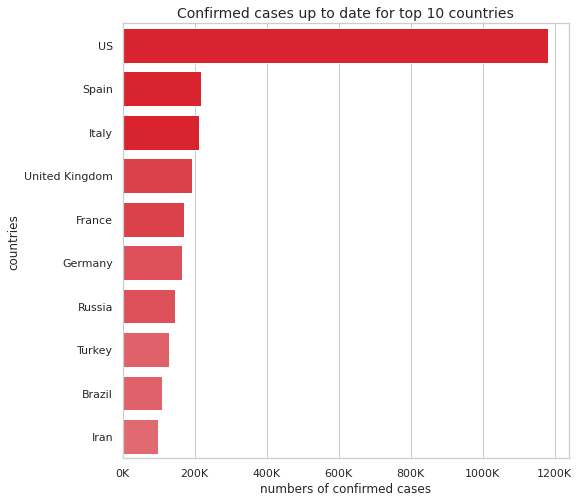

In [10]:
countries_top10=[]
confirmed_top10=[]
for tup in sorted(confirmed_cases['4/22/20'].items(),key=lambda x: x[1],reverse=True)[:10]:
  countries_top10.append(tup[0])
  confirmed_top10.append(tup[1])
c = ['#f70514','#f70514','#f70514','#f52734','#f52734','#f53844','#f53844','#f54c57','#f54c57','#f55660']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8)})
g = sns.barplot(confirmed_top10,countries_top10)
title='Confirmed cases up to date for top 10 countries'
x_labels = [str(int(x)) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(x_labels,fontdict={'fontsize':11})
g.set_yticklabels(g.get_yticklabels(),fontdict={'fontsize':11})
g.set_xlabel('numbers of confirmed cases',fontdict={'fontsize':12})
g.set_ylabel('countries',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

### Explore global death cases

Check the null values.

In [11]:
check_null(deaths_global)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
nums of NaNs,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Drop 	"Province/State" column.

In [0]:
deaths_global = deaths_global.drop(columns=['Province/State'])

From the dataset, we can observe that the number of deaths cases is cumulative by date for every country.

Explores the dataset by countries and dates.

In [0]:
# Make a deep copy of the returned dictionary when exploring the dataset by countries and dates.
deaths_cases = copy.deepcopy(Explore_cases_by_countries_and_dates(deaths_global))

What are the top 10 countries that have the most death cases up to date?

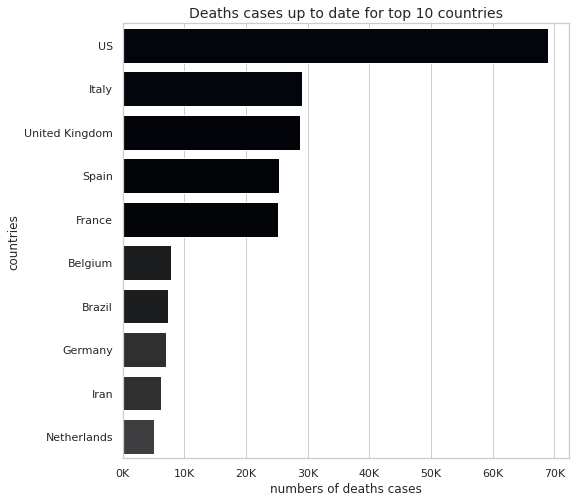

In [14]:
countries_top10=[]
deaths_top10=[]
for tup in sorted(deaths_cases['4/22/20'].items(),key=lambda x: x[1],reverse=True)[:10]:
  countries_top10.append(tup[0])
  deaths_top10.append(tup[1])
c=['#01030d','#02040d','#02040a','#020308','#020308','#1c1d1f','#1c1d1f','#2f2f30','#2f2f30','#3e3e40']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8)})
g = sns.barplot(deaths_top10,countries_top10)
title='Deaths cases up to date for top 10 countries'
x_labels = [str(int(x)) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(x_labels,fontdict={'fontsize':11})
g.set_yticklabels(g.get_yticklabels(),fontdict={'fontsize':11})
g.set_xlabel('numbers of deaths cases',fontdict={'fontsize':12})
g.set_ylabel('countries',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

### Explore global recovered cases

Check null values.

In [15]:
check_null(recovered_global)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
nums of NaNs,185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Drop "Province/State" column.

In [0]:
recovered_global = recovered_global.drop(columns=['Province/State'])

From the dataset, we can observe that the number of recovered cases is cumulative by date for every country.

Explores the dataset by countries and dates.

In [0]:
recovered_cases = copy.deepcopy(Explore_cases_by_countries_and_dates(recovered_global))

What are the top 10 countries that have the most recovered cases up to date?

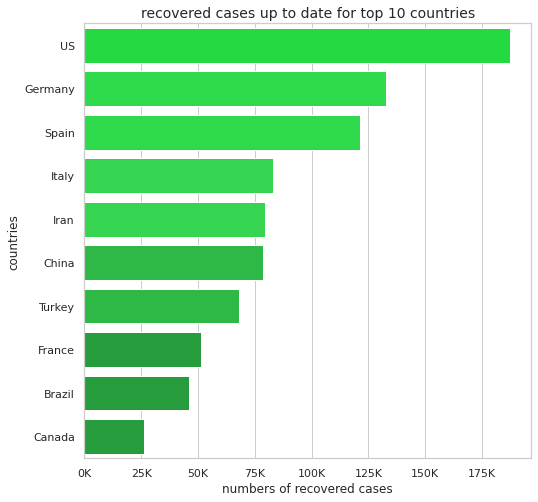

In [18]:
countries_top10=[]
recovered_top10=[]
for tup in sorted(recovered_cases['4/22/20'].items(),key=lambda x: x[1],reverse=True)[:10]:
  countries_top10.append(tup[0])
  recovered_top10.append(tup[1])
c=['#07f72f','#11f738','#11f738','#1af03f','#1af03f','#17cf37','#17cf37','#13b02f','#13b02f','#13b02f']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8)})
g = sns.barplot(recovered_top10,countries_top10)
title='recovered cases up to date for top 10 countries'
x_labels = [str(int(x)) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(x_labels,fontdict={'fontsize':11})
g.set_yticklabels(g.get_yticklabels(),fontdict={'fontsize':11})
g.set_xlabel('numbers of recovered cases',fontdict={'fontsize':12})
g.set_ylabel('countries',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

Let's see the respective mortality rate and recovery rate among the top10 countries in terms of the confirmed cases. 

Explore mortality rate

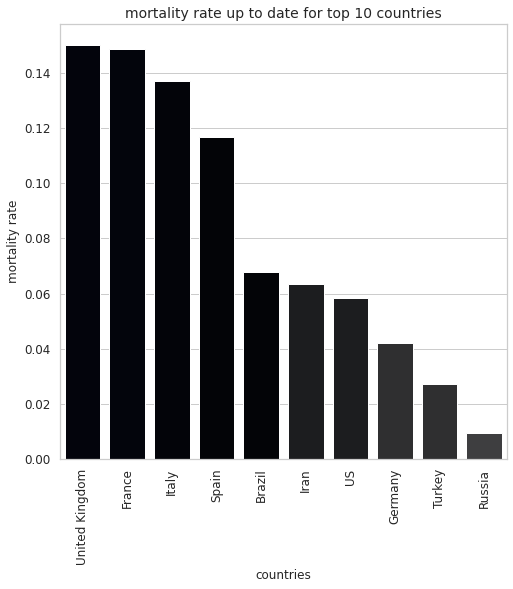

In [19]:
confirmed_top10 = sorted(confirmed_cases['4/22/20'].items(),key=lambda x: x[1],reverse=True)[:10]
countries_to_mortalities={}
countries_mortality=[]
mortalities=[]
for country, confirm_num in confirmed_top10:
  deaths = deaths_cases['4/22/20'][country]
  mortality_rate = deaths/confirm_num
  countries_to_mortalities[country] = mortality_rate

for tup in sorted(countries_to_mortalities.items(),key=lambda x: x[1],reverse=True):
  countries_mortality.append(tup[0])
  mortalities.append(tup[1])

c=['#01030d','#02040d','#02040a','#020308','#020308','#1c1d1f','#1c1d1f','#2f2f30','#2f2f30','#3e3e40']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8),'xtick.labelsize':12,'ytick.labelsize':12})
g = sns.barplot(countries_mortality,mortalities)
title='mortality rate up to date for top 10 countries'
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('countries',fontdict={'fontsize':12})
g.set_ylabel('mortality rate',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

Explore recovery rate

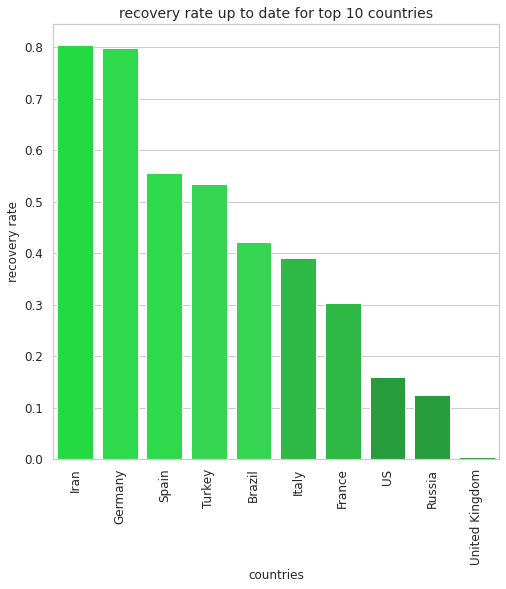

In [20]:
confirmed_top10 = sorted(confirmed_cases['4/22/20'].items(),key=lambda x: x[1],reverse=True)[:10]
countries_to_recovery={}
countries_recovery=[]
recovery=[]
for country, confirm_num in confirmed_top10:
  recovery_num = recovered_cases['4/22/20'][country]
  recovery_rate = recovery_num/confirm_num
  countries_to_recovery[country] = recovery_rate

for tup in sorted(countries_to_recovery.items(),key=lambda x: x[1],reverse=True):
  countries_recovery.append(tup[0])
  recovery.append(tup[1])

c=['#07f72f','#11f738','#11f738','#1af03f','#1af03f','#17cf37','#17cf37','#13b02f','#13b02f','#13b02f']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8),'xtick.labelsize':12,'ytick.labelsize':12})
g = sns.barplot(countries_recovery,recovery)
title='recovery rate up to date for top 10 countries'
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('countries',fontdict={'fontsize':12})
g.set_ylabel('recovery rate',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

Visualize the confirmed cases since 1/22/2020 for US, Italy, Sapin, France and Germany.

In [0]:
# Calculate the duration between 1/22/2020 and the latest record in the dataset
duration = (datetime.strptime(confirmed_global.keys()[-1],'%m/%d/%y') \
            - datetime.strptime(confirmed_global.keys()[3],'%m/%d/%y')).days

In [0]:
aggrn = {}
for date in confirmed_global.keys()[3:]:
  aggrn[date]='sum'
# Do summation of confirmed cases for each country
confirmed_by_countries = confirmed_global.groupby(by='Country/Region').agg(aggrn).reset_index()

In [0]:
y_us = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='US'].iloc[0])[1:]
y_italy = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='Italy'].iloc[0])[1:]
y_spain = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='Spain'].iloc[0])[1:]
y_france = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='France'].iloc[0])[1:]
y_germany = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='Germany'].iloc[0])[1:]

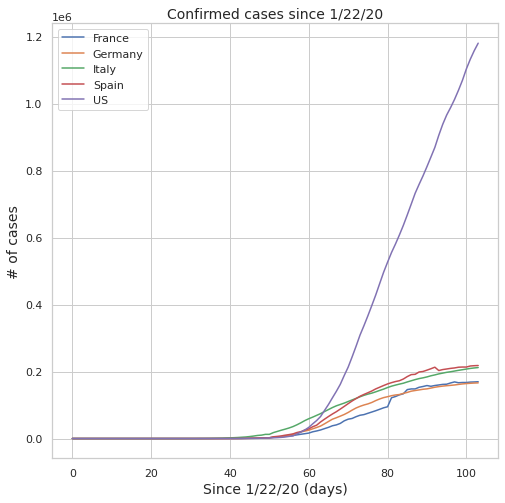

In [24]:
sns.set(style='whitegrid',rc={'figure.figsize':(8,8),'xtick.labelsize':11,'ytick.labelsize':11})
g = sns.lineplot(range(duration+1),y_france)
g = sns.lineplot(range(duration+1),y_germany)
g = sns.lineplot(range(duration+1),y_italy)
g = sns.lineplot(range(duration+1),y_spain)
g = sns.lineplot(range(duration+1),y_us)

title='Confirmed cases since 1/22/20'
g.set_xlabel('Since 1/22/20 (days)',fontdict={'fontsize':14})
g.set_ylabel('# of cases',fontdict={'fontsize':14})
g_title_text = g.set_title(title,fontdict={'fontsize':14})
g.legend(['France','Germany','Italy','Spain','US'])

## Part II - Explore different regression techniques for predicting confirmed cases within US in the next 10 days 

In [25]:
confirmed_US = confirmed_by_countries[confirmed_by_countries['Country/Region']=='US']
confirmed_US

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20
173,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,...,83836,101657,121465,140909,161831,188172,213242,243622,275367,308650,336802,366317,397121,428654,462780,496535,526396,555313,580619,607670,636350,667592,699706,732197,758809,784326,811865,840351,869170,905358,938154,965785,988197,1012582,1039909,1069424,1103461,1132539,1158040,1180375


In [0]:
# Set X and y for training
X_days = np.array(range(len(confirmed_US.keys()[1:])))
y_confirmed_num_US = [int(confirmed_US[key].values) for key in confirmed_US.keys()[1:]]

In [0]:
# Generate train and test datasets respectively
x_train_US,x_test_US,y_train_US,y_test_US = train_test_split(X_days,y_confirmed_num_US,train_size=0.9,test_size=0.1,shuffle=False)

In [0]:
# Rescale the shape of the datasets to a higher dimension
x_train_US = x_train_US[:,None]
x_test_US = x_test_US[:,None]

### Linear Regression

Explore different degrees of polynomials used for prediction. Decide the degree that fit the data most by evaluating the Root Mean Square Error between the prediction values and the true values, using the test dataset.

The upper six plots show the prediction values and true values of training dataset. 

The lower six plots show the prediction values and true values of test dataset. 

We can observe that as the degree of polynomial increases, the predicted curve and the true curve of training dataset become closer and closer, whereas the predicted curve and the true curve of test dataset first become closer, then diverge (as shown in printed RMSE errors). 

**This reflect that as degree of polynomial becomes too large, the model will become overfitting. We also cannot choose a degree of polynomial that is too small because the model will be underfitting in that case. Therefore, we choose the model which yields the lowest RMSE error.**

Respectively, RMSE errors from first degree to six degree are:  
 520018.40871213836 
 70340.48454050477 
 234281.94556410203 
 201567.40433165818 
 115983.90197480969 
 378809.69226744224


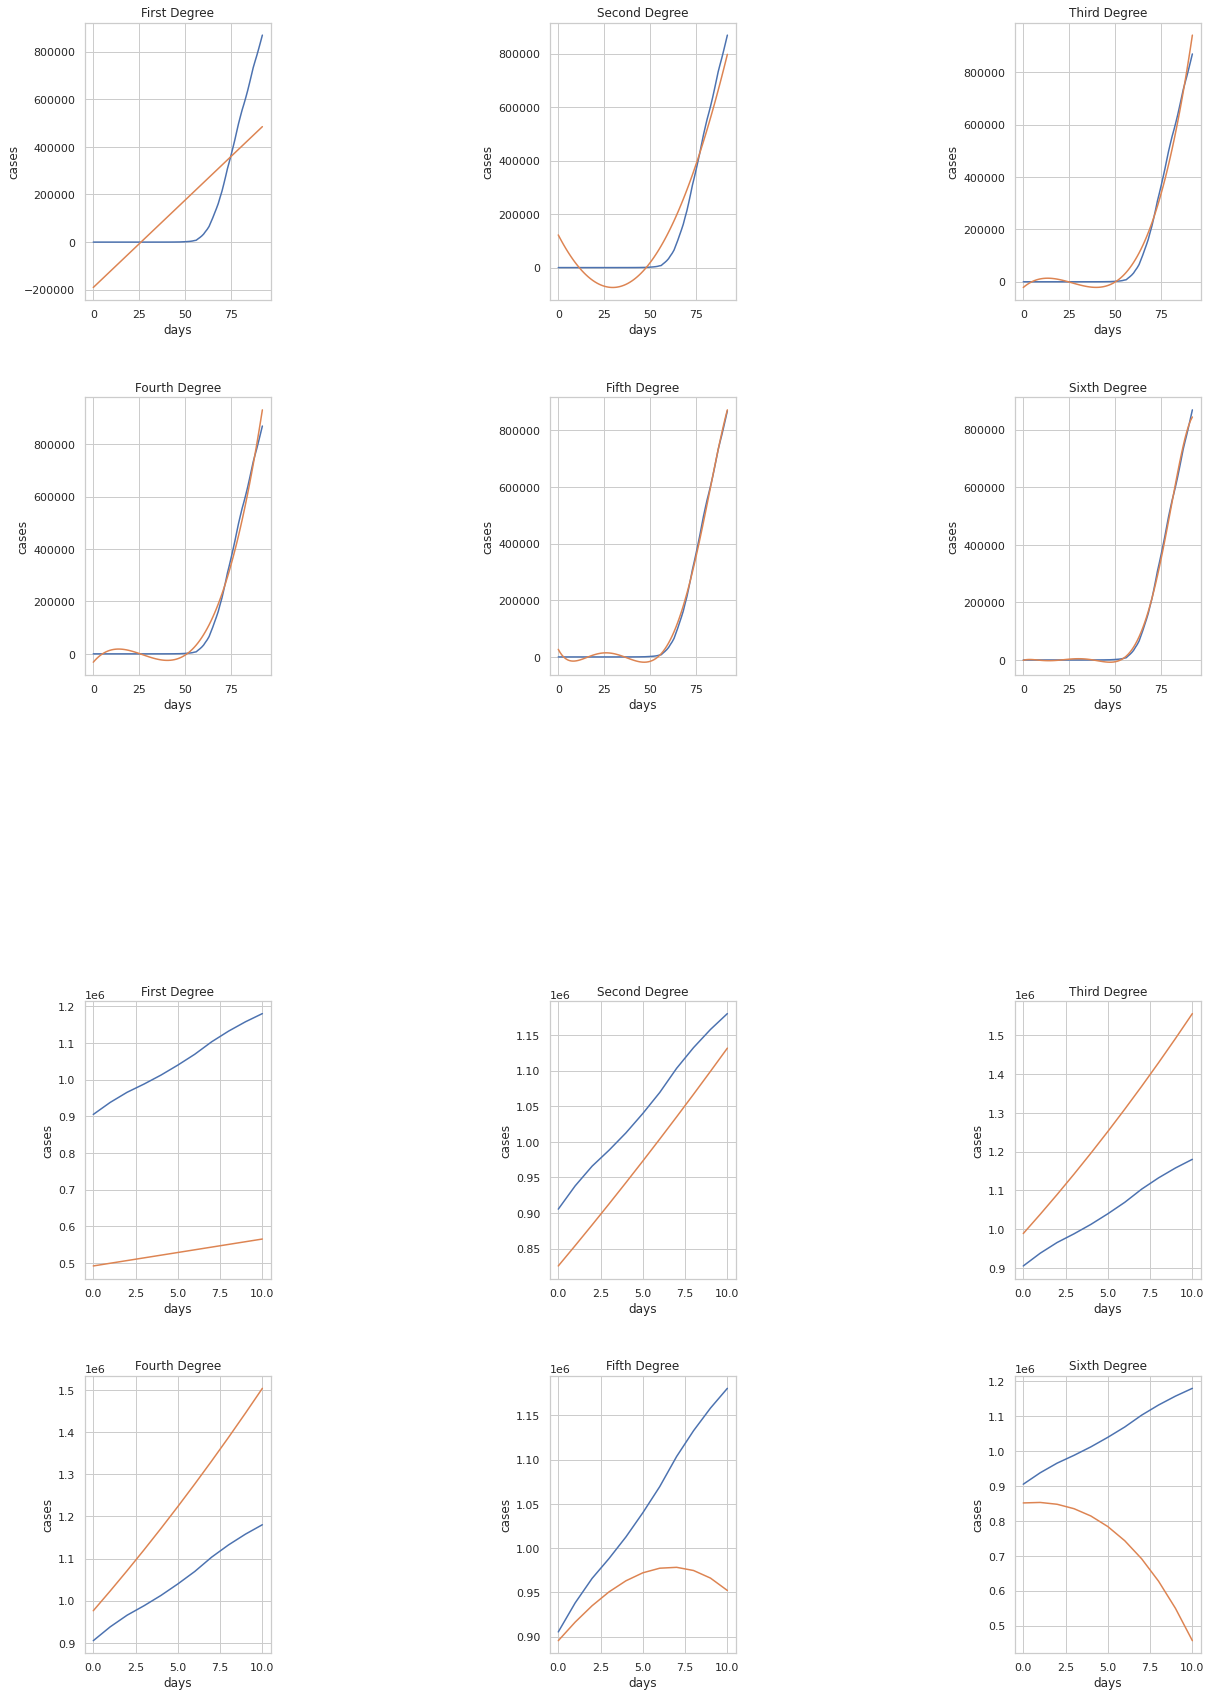

In [29]:
fig = plt.figure(figsize=(20, 30))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
#model1
poly_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_1 = poly_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_1.fit_transform(x_test_US)
#Train polynomial linear regression model
model1 = LinearRegression(normalize=False).fit(x_train_US_transformed_1,y_train_US)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US)
ax.plot(model1.predict(x_train_US_transformed_1))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)
#model2
poly_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_2 = poly_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_2.fit_transform(x_test_US)
#Train polynomial linear regression model
model2 = LinearRegression(normalize=False).fit(x_train_US_transformed_2,y_train_US)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US)
ax.plot(model2.predict(x_train_US_transformed_2))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)
#model3
poly_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_3 = poly_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_3.fit_transform(x_test_US)
#Train polynomial linear regression model
model3 = LinearRegression(normalize=False).fit(x_train_US_transformed_3,y_train_US)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US)
ax.plot(model3.predict(x_train_US_transformed_3))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)
#model4
poly_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_4 = poly_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_4.fit_transform(x_test_US)
#Train polynomial linear regression model
model4 = LinearRegression(normalize=False).fit(x_train_US_transformed_4,y_train_US)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US)
ax.plot(model4.predict(x_train_US_transformed_4))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)
#model5
poly_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_5 = poly_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_5.fit_transform(x_test_US)
#Train polynomial linear regression model
model5 = LinearRegression(normalize=False).fit(x_train_US_transformed_5,y_train_US)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US)
ax.plot(model5.predict(x_train_US_transformed_5))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)
#model6
poly_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_6.fit_transform(x_test_US)
#Train polynomial linear regression model
model6 = LinearRegression(normalize=False).fit(x_train_US_transformed_6,y_train_US)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US)
ax.plot(model6.predict(x_train_US_transformed_6))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)


y_pred_US_1 = model1.predict(x_test_US_transformed_1)
rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US)
ax.plot(y_pred_US_1)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


y_pred_US_2 = model2.predict(x_test_US_transformed_2)
rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US)
ax.plot(y_pred_US_2)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


y_pred_US_3 = model3.predict(x_test_US_transformed_3)
rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US)
ax.plot(y_pred_US_3)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


y_pred_US_4 = model4.predict(x_test_US_transformed_4)
rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US)
ax.plot(y_pred_US_4)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)


y_pred_US_5 = model5.predict(x_test_US_transformed_5)
rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US)
ax.plot(y_pred_US_5)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)


y_pred_US_6 = model6.predict(x_test_US_transformed_6)
rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US)
ax.plot(y_pred_US_6)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()

print('Respectively, RMSE errors from first degree to six degree are: ','\n',rmse1,'\n',rmse2,'\n',rmse3,'\n',rmse4,'\n',rmse5,'\n',rmse6)

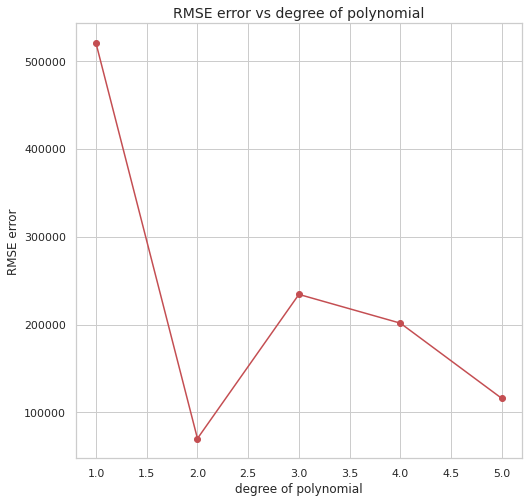

In [30]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,6),[rmse1,rmse2,rmse3,rmse4,rmse5],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Lasso Regression

Still, we choose the model which yields the lowest RMSE error.

In [31]:

#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_L_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_L_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_L_1.fit_transform(x_test_US)
# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9]

warm_start=[True,False]
# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}
#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_1 = lasso_search.best_estimator_


#model2
#Set up second degree polynomial feature, transform data to 3D data
poly_L_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_L_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_L_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_2 = lasso_search.best_estimator_

#model3
#Set up third degree polynomial feature, transform data to 4D data
poly_L_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_L_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_L_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_3 = lasso_search.best_estimator_


#model4
#Set up fourth degree polynomial feature, transform data to 5D data
poly_L_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_L_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_L_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_4 = lasso_search.best_estimator_


#model5
#Set up fifth degree polynomial feature, transform data to 6D data
poly_L_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_L_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_L_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_5 = lasso_search.best_estimator_


#model6
#Set up sixth degree polynomial feature, transform data to 7D data
poly_L_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_L_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_L_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_6 = lasso_search.best_estimator_


Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-05, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28805073430.343517, tolerance: 5.916496129933313
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': False, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052421258.8402786, tolerance: 5.916496129933313
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9094928125.218704, tolerance: 5.916496129933313
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}




[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8634973544.348846, tolerance: 5.916496129933313
  positive)


Respectively, RMSE errors from first degree to six degree are:  
 520205.17720096133 
 72416.9085857246 
 215207.55132868743 
 268151.238944117 
 262864.28696754714 
 239565.9957077801


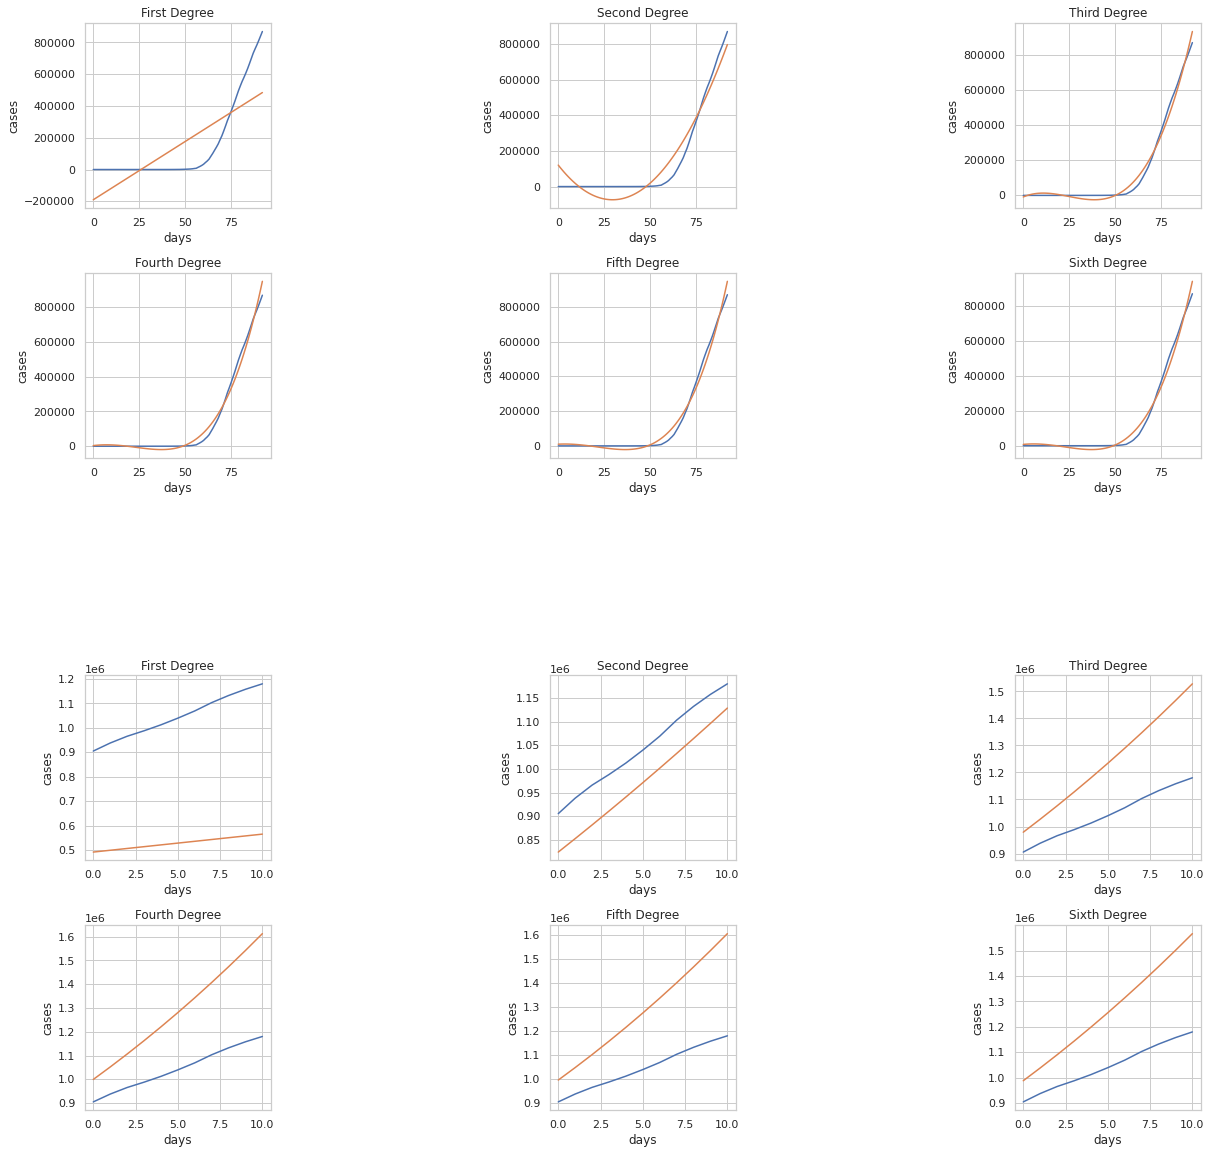

In [32]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US)
ax.plot(lasso_confirmed_1.predict(x_train_US_transformed_1))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US)
ax.plot(lasso_confirmed_2.predict(x_train_US_transformed_2))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US)
ax.plot(lasso_confirmed_3.predict(x_train_US_transformed_3))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US)
ax.plot(lasso_confirmed_4.predict(x_train_US_transformed_4))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US)
ax.plot(lasso_confirmed_5.predict(x_train_US_transformed_5))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US)
ax.plot(lasso_confirmed_6.predict(x_train_US_transformed_6))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = lasso_confirmed_1.predict(x_test_US_transformed_1)
L_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US)
ax.plot(y_pred_US_1)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = lasso_confirmed_2.predict(x_test_US_transformed_2)
L_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US)
ax.plot(y_pred_US_2)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = lasso_confirmed_3.predict(x_test_US_transformed_3)
L_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US)
ax.plot(y_pred_US_3)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = lasso_confirmed_4.predict(x_test_US_transformed_4)
L_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US)
ax.plot(y_pred_US_4)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = lasso_confirmed_5.predict(x_test_US_transformed_5)
L_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US)
ax.plot(y_pred_US_5)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = lasso_confirmed_6.predict(x_test_US_transformed_6)
L_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US)
ax.plot(y_pred_US_6)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',L_rmse1,'\n',L_rmse2,'\n',L_rmse3,'\n',L_rmse4,'\n',L_rmse5,'\n',L_rmse6)

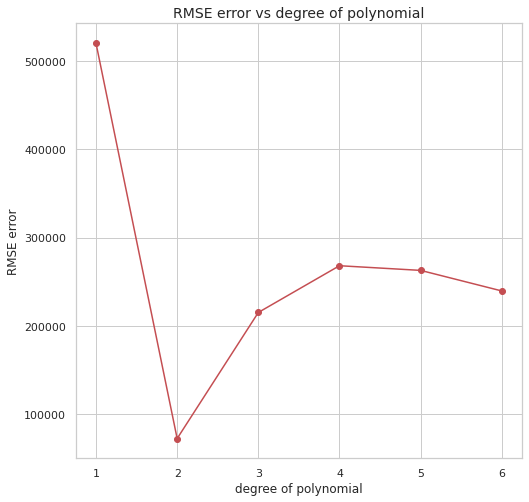

In [33]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[L_rmse1,L_rmse2,L_rmse3,L_rmse4,L_rmse5,L_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Ridge Regression

Still, we choose the model which yields the lowest RMSE error.

In [34]:
#model1
#Set up second degree polynomial feature, transform data to 3D data
poly_R_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_R_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_R_1.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_1 = ridge_search.best_estimator_



#model2
#Set up second degree polynomial feature, transform data to 3D data
poly_R_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_R_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_R_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_2 = ridge_search.best_estimator_


#model3
#Set up second degree polynomial feature, transform data to 3D data
poly_R_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_R_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_R_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}
#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_3 = ridge_search.best_estimator_



#model4
#Set up second degree polynomial feature, transform data to 3D data
poly_R_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_R_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_R_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_4 = ridge_search.best_estimator_



#model5
#Set up second degree polynomial feature, transform data to 3D data
poly_R_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_R_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_R_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_5 = ridge_search.best_estimator_



#model6
#Set up second degree polynomial feature, transform data to 3D data
poly_R_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_R_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_R_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_6 = ridge_search.best_estimator_


Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 2, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.11541e-20): result may not be accurate.
  overwrite_a=True).T
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1e-07, 'normalize': False, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.001, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits
The parameter set for the best estimator: {'alpha': 0.1, 'normalize': True, 'tol': 1e-06}


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.6s finished


Respectively, RMSE errors from first degree to six degree are:  
 774610.9421777503 
 150789.9199859319 
 234281.94555558832 
 256072.25071770596 
 269533.76293030987 
 259025.610142548


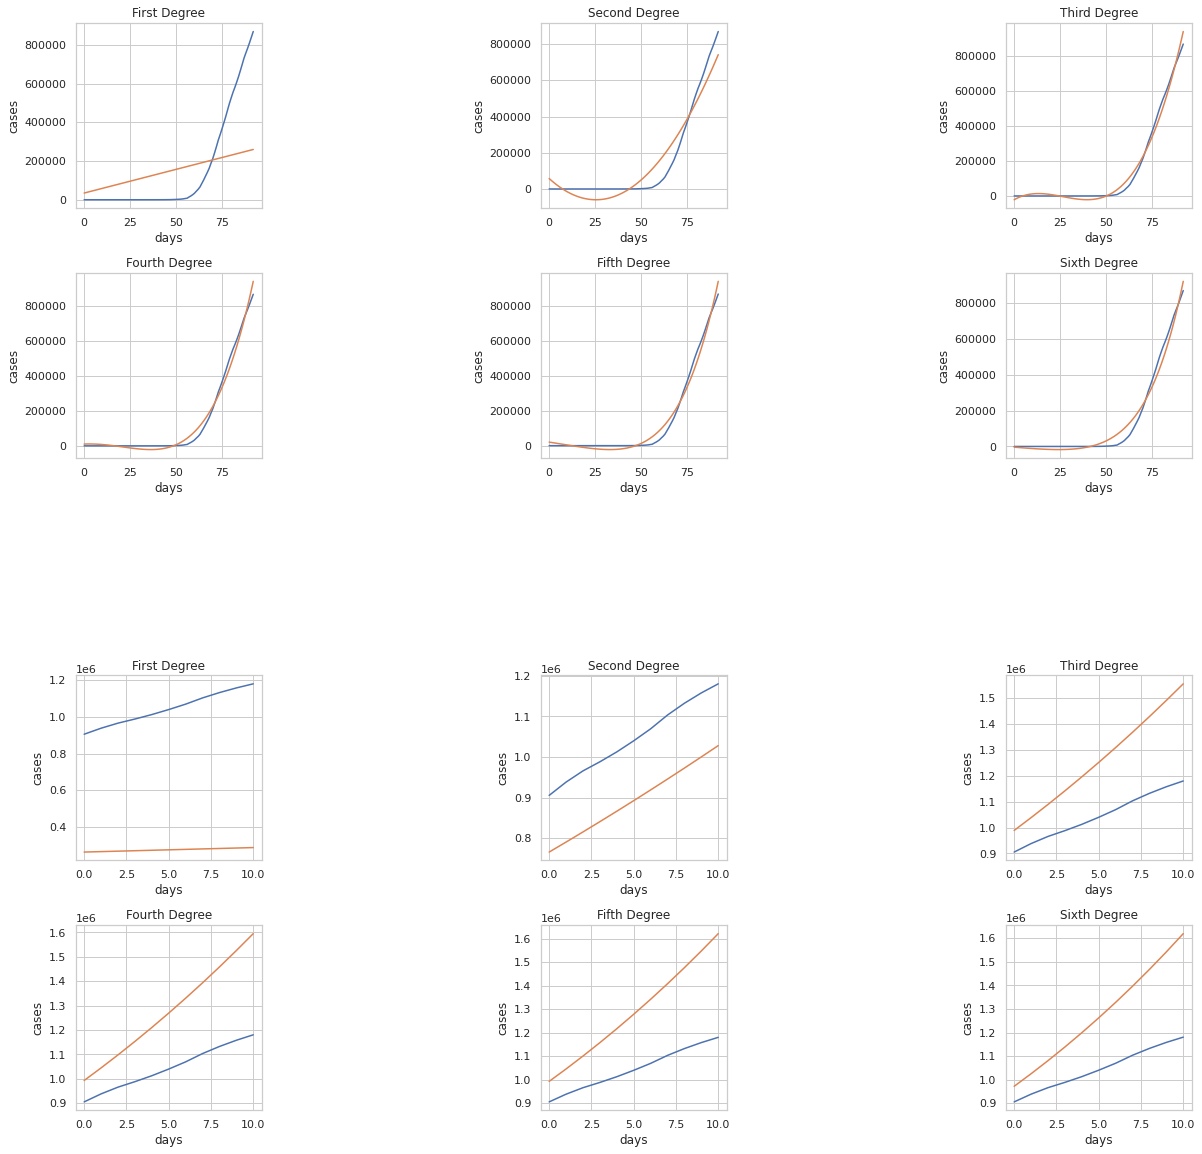

In [35]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US)
ax.plot(ridge_confirmed_1.predict(x_train_US_transformed_1))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US)
ax.plot(ridge_confirmed_2.predict(x_train_US_transformed_2))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US)
ax.plot(ridge_confirmed_3.predict(x_train_US_transformed_3))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US)
ax.plot(ridge_confirmed_4.predict(x_train_US_transformed_4))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US)
ax.plot(ridge_confirmed_5.predict(x_train_US_transformed_5))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US)
ax.plot(ridge_confirmed_6.predict(x_train_US_transformed_6))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = ridge_confirmed_1.predict(x_test_US_transformed_1)
R_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US)
ax.plot(y_pred_US_1)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = ridge_confirmed_2.predict(x_test_US_transformed_2)
R_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US)
ax.plot(y_pred_US_2)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = ridge_confirmed_3.predict(x_test_US_transformed_3)
R_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US)
ax.plot(y_pred_US_3)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = ridge_confirmed_4.predict(x_test_US_transformed_4)
R_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US)
ax.plot(y_pred_US_4)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = ridge_confirmed_5.predict(x_test_US_transformed_5)
R_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US)
ax.plot(y_pred_US_5)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = ridge_confirmed_6.predict(x_test_US_transformed_6)
R_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US)
ax.plot(y_pred_US_6)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',R_rmse1,'\n',R_rmse2,'\n',R_rmse3,'\n',R_rmse4,'\n',R_rmse5,'\n',R_rmse6)

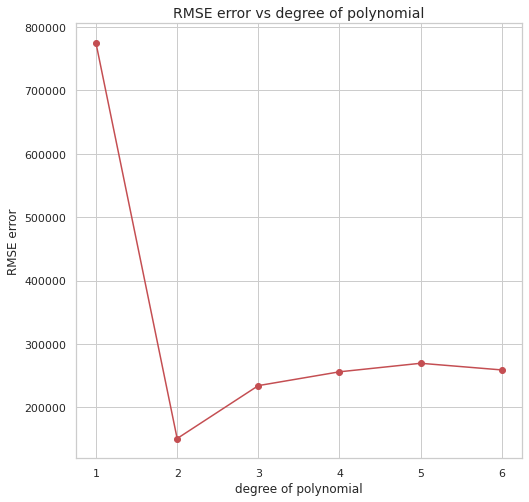

In [36]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[R_rmse1,R_rmse2,R_rmse3,R_rmse4,R_rmse5,R_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### ElasticNet Regression (Combine Lasso and Ridge)

Still, we choose the model which yields the lowest RMSE error.

In [37]:
#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_E_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_E_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_E_1.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_1 = elastic_search.best_estimator_



#model2
#Set up first degree polynomial feature, transform data to 2D data
poly_E_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_E_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_E_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_2 = elastic_search.best_estimator_


#model3
#Set up third degree polynomial feature, transform data to 2D data
poly_E_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_E_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_E_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_3 = elastic_search.best_estimator_



#model4
#Set up fourth degree polynomial feature, transform data to 5D data
poly_E_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_E_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_E_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_4 = elastic_search.best_estimator_



#model5
#Set up first degree polynomial feature, transform data to 2D data
poly_E_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_E_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_E_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_5 = elastic_search.best_estimator_



#model6
#Set up first degree polynomial feature, transform data to 2D data
poly_E_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_E_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_E_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_6 = elastic_search.best_estimator_

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.1, 'l1_ratio': 0.8, 'normalize': True, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.001, 'l1_ratio': 0.8, 'normalize': True, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    5.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32063760068.046673, tolerance: 591649612.9933314
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 5, 'l1_ratio': 0.3, 'normalize': False, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    5.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31953813406.092175, tolerance: 591649612.9933314
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 5, 'l1_ratio': 0.001, 'normalize': False, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.001, 'l1_ratio': 0.5, 'normalize': True, 'tol': 0.01, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s


The parameter set for the best estimator: {'alpha': 0.001, 'l1_ratio': 0.01, 'normalize': True, 'tol': 0.01, 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    5.3s finished


Respectively, RMSE errors from first degree to six degree are:  
 768377.4502076634 
 196144.70358875958 
 208508.309704732 
 260762.83451426413 
 210356.67249543424 
 264386.69947954937


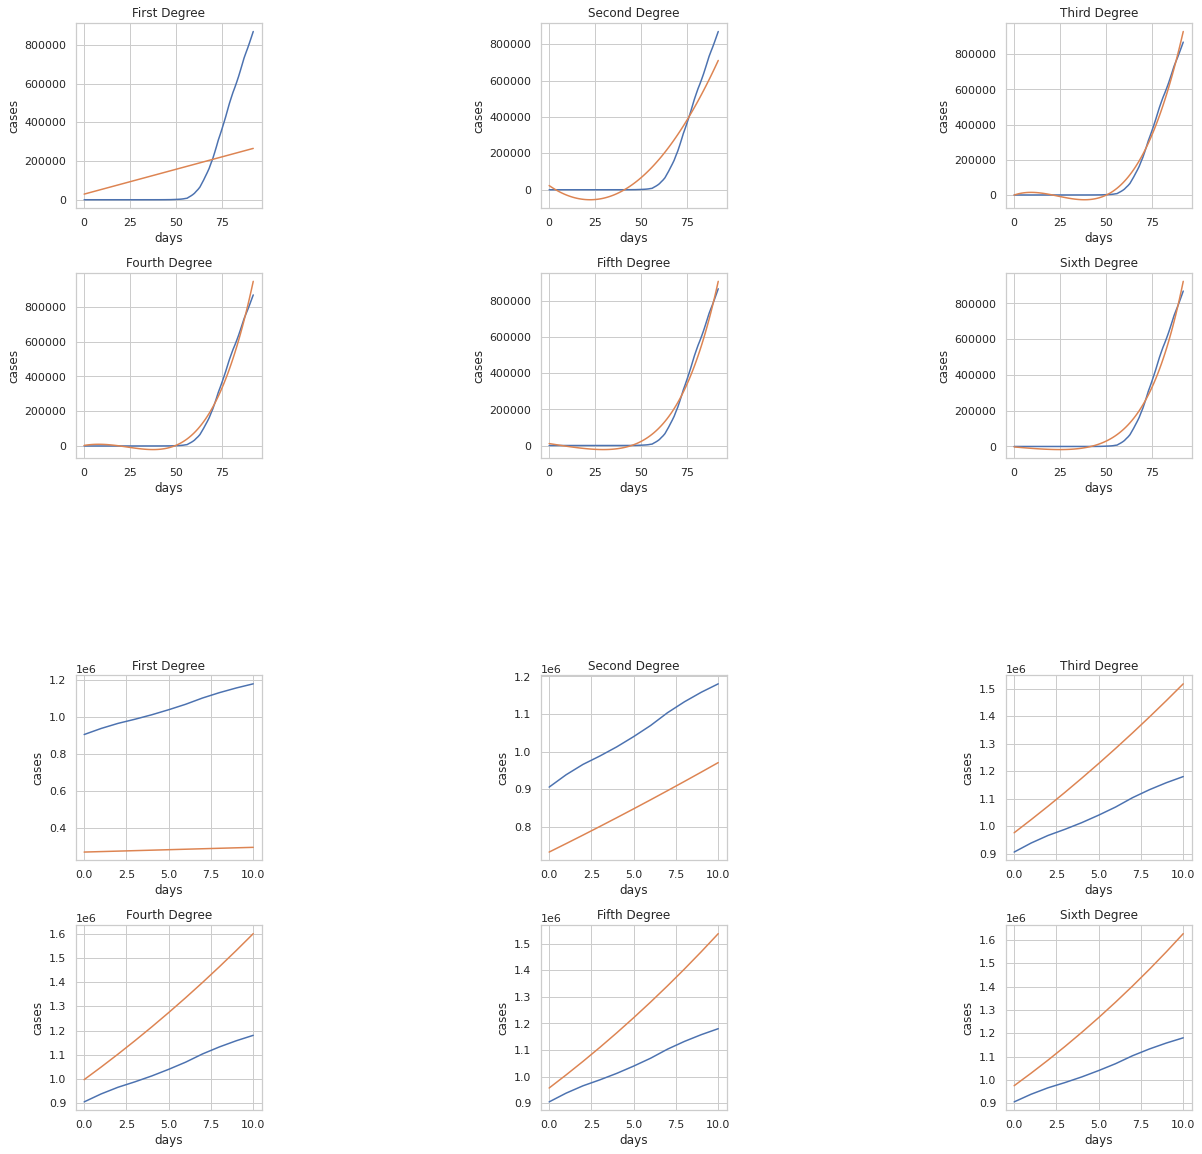

In [38]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US)
ax.plot(elastic_confirmed_1.predict(x_train_US_transformed_1))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US)
ax.plot(elastic_confirmed_2.predict(x_train_US_transformed_2))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US)
ax.plot(elastic_confirmed_3.predict(x_train_US_transformed_3))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US)
ax.plot(elastic_confirmed_4.predict(x_train_US_transformed_4))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US)
ax.plot(elastic_confirmed_5.predict(x_train_US_transformed_5))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US)
ax.plot(elastic_confirmed_6.predict(x_train_US_transformed_6))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = elastic_confirmed_1.predict(x_test_US_transformed_1)
E_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US)
ax.plot(y_pred_US_1)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = elastic_confirmed_2.predict(x_test_US_transformed_2)
E_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US)
ax.plot(y_pred_US_2)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = elastic_confirmed_3.predict(x_test_US_transformed_3)
E_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US)
ax.plot(y_pred_US_3)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = elastic_confirmed_4.predict(x_test_US_transformed_4)
E_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US)
ax.plot(y_pred_US_4)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = elastic_confirmed_5.predict(x_test_US_transformed_5)
E_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US)
ax.plot(y_pred_US_5)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = elastic_confirmed_6.predict(x_test_US_transformed_6)
E_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US)
ax.plot(y_pred_US_6)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',E_rmse1,'\n',E_rmse2,'\n',E_rmse3,'\n',E_rmse4,'\n',E_rmse5,'\n',E_rmse6)

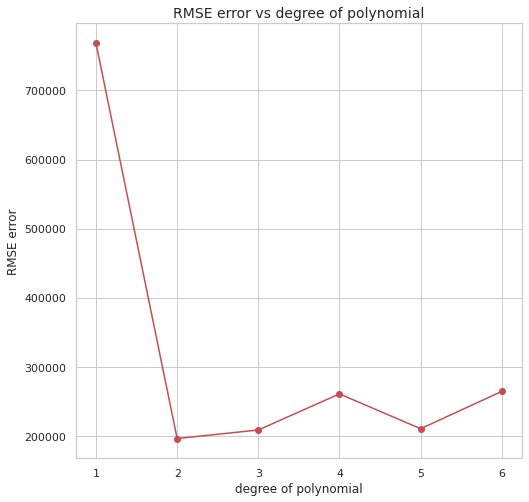

In [39]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[E_rmse1,E_rmse2,E_rmse3,E_rmse4,E_rmse5,E_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Bayesian Ridge Regression (Assume Beta prior for initialization of weights and bias)

Still, we choose the model which yields the lowest RMSE error.

In [40]:
#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_r_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_r_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_r_1.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_1 = bayesian_search.best_estimator_



#model2
#Set up first degree polynomial feature, transform data to 2D data
poly_r_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_r_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_r_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_2 = bayesian_search.best_estimator_


#model3
#Set up third degree polynomial feature, transform data to 2D data
poly_r_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_r_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_r_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_3 = bayesian_search.best_estimator_



#model4
#Set up fourth degree polynomial feature, transform data to 5D data
poly_r_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_r_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_r_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_4 = bayesian_search.best_estimator_



#model5
#Set up first degree polynomial feature, transform data to 2D data
poly_r_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_r_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_r_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_5 = bayesian_search.best_estimator_



#model6
#Set up first degree polynomial feature, transform data to 2D data
poly_r_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_r_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_r_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_6 = bayesian_search.best_estimator_

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 0.1, 'alpha_2': 0.001, 'lambda_1': 0.01, 'lambda_2': 2, 'tol': 1e-06}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 2, 'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 2, 'tol': 0.001}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 2, 'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 2, 'tol': 1e-06}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 0.001, 'alpha_2': 2, 'lambda_1': 2, 'lambda_2': 2, 'tol': 0.001}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 0.001, 'alpha_2': 2, 'lambda_1': 1, 'lambda_2': 0.01, 'tol': 0.001}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:    9.3s


The parameter set for the best estimator: {'alpha_1': 2, 'alpha_2': 0.1, 'lambda_1': 0.001, 'lambda_2': 2, 'tol': 0.001}


[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:   11.8s finished


Respectively, RMSE errors from first degree to six degree are:  
 522713.94703946775 
 296738.703387145 
 174099.4982492406 
 308812.94847249397 
 355916.00853767357 
 277985.77340029617


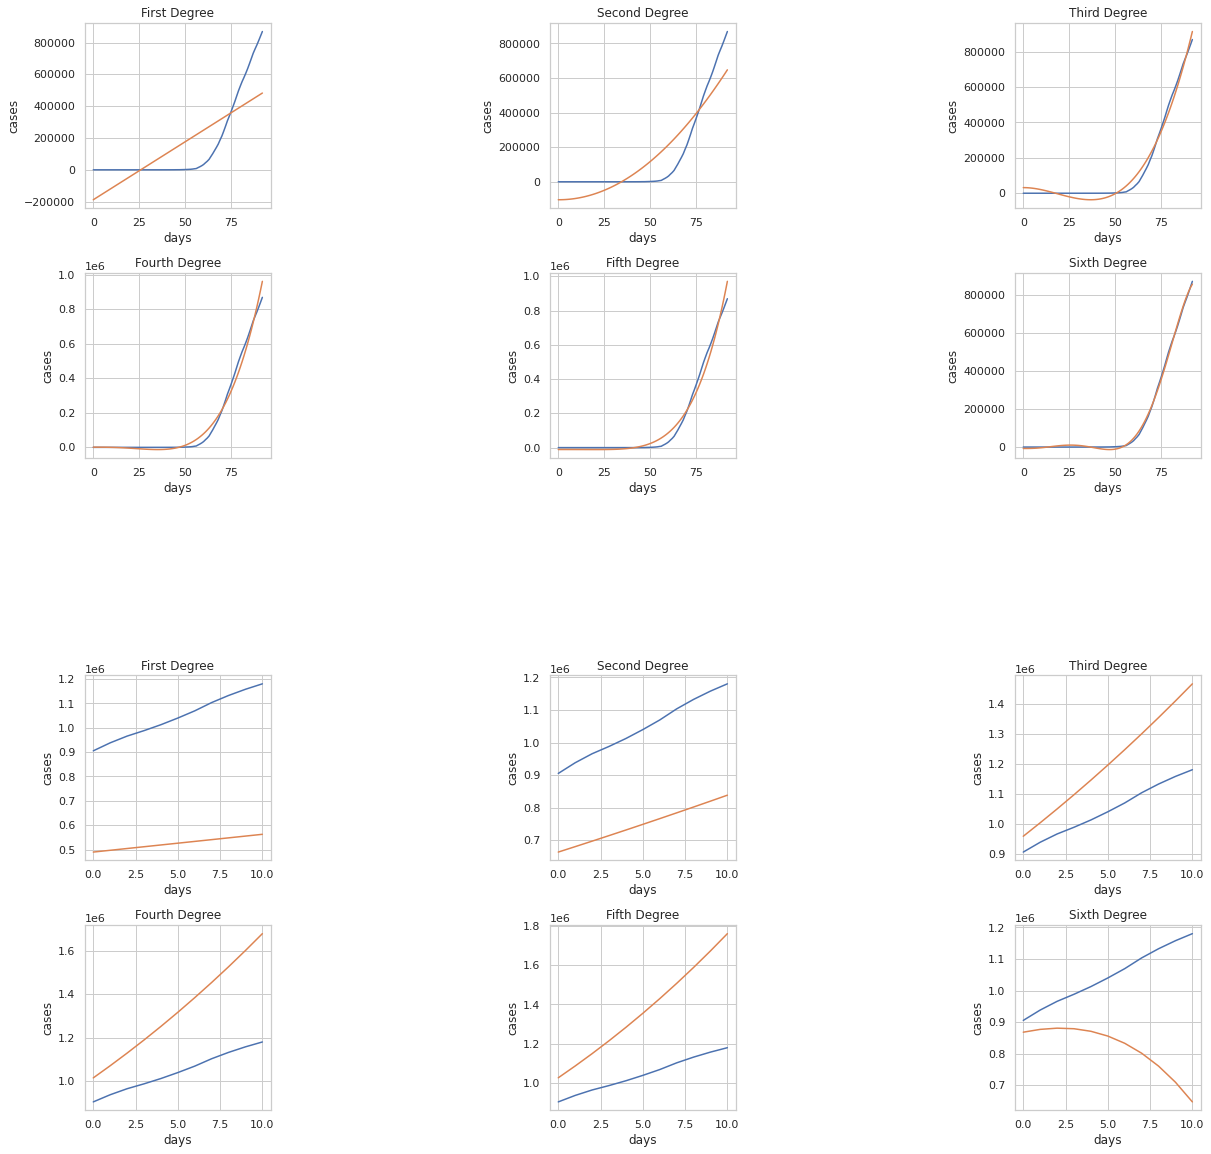

In [41]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US)
ax.plot(bayesian_confirmed_1.predict(x_train_US_transformed_1))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US)
ax.plot(bayesian_confirmed_2.predict(x_train_US_transformed_2))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US)
ax.plot(bayesian_confirmed_3.predict(x_train_US_transformed_3))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US)
ax.plot(bayesian_confirmed_4.predict(x_train_US_transformed_4))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US)
ax.plot(bayesian_confirmed_5.predict(x_train_US_transformed_5))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US)
ax.plot(bayesian_confirmed_6.predict(x_train_US_transformed_6))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = bayesian_confirmed_1.predict(x_test_US_transformed_1)
BR_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US)
ax.plot(y_pred_US_1)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = bayesian_confirmed_2.predict(x_test_US_transformed_2)
BR_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US)
ax.plot(y_pred_US_2)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = bayesian_confirmed_3.predict(x_test_US_transformed_3)
BR_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US)
ax.plot(y_pred_US_3)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = bayesian_confirmed_4.predict(x_test_US_transformed_4)
BR_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US)
ax.plot(y_pred_US_4)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = bayesian_confirmed_5.predict(x_test_US_transformed_5)
BR_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US)
ax.plot(y_pred_US_5)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = bayesian_confirmed_6.predict(x_test_US_transformed_6)
BR_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US)
ax.plot(y_pred_US_6)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',BR_rmse1,'\n',BR_rmse2,'\n',BR_rmse3,'\n',BR_rmse4,'\n',BR_rmse5,'\n',BR_rmse6)

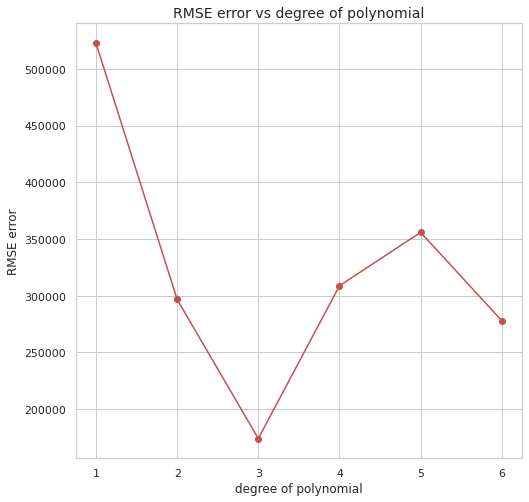

In [42]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[BR_rmse1,BR_rmse2,BR_rmse3,BR_rmse4,BR_rmse5,BR_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Huber Regression (Stress the importance of outliers in this dataset)

Still, we choose the model which yields the lowest RMSE error.

In [43]:
#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_H_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_H_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_H_1.fit_transform(x_test_US)
# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_1 = Huber_search.best_estimator_

#model2
#Set up first degree polynomial feature, transform data to 2D data
poly_H_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_H_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_H_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_2 = Huber_search.best_estimator_

#model3
#Set up first degree polynomial feature, transform data to 2D data
poly_H_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_H_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_H_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_3 = Huber_search.best_estimator_

#model4
#Set up first degree polynomial feature, transform data to 2D data
poly_H_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_H_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_H_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_4 = Huber_search.best_estimator_

#model5
#Set up first degree polynomial feature, transform data to 2D data
poly_H_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_H_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_H_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_5 = Huber_search.best_estimator_

#model6
#Set up first degree polynomial feature, transform data to 2D data
poly_H_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_H_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_H_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_6 = Huber_search.best_estimator_

Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1, 'epsilon': 2, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   26.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.1, 'epsilon': 4, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   32.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1e-07, 'epsilon': 3.5, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   33.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1e-06, 'epsilon': 5, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   32.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1, 'epsilon': 2, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   19.8s


The parameter set for the best estimator: {'alpha': 0.1, 'epsilon': 4, 'tol': 1e-06, 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   33.9s finished


Respectively, RMSE errors from first degree to six degree are:  
 840325.2196769837 
 221487.27068694046 
 133372.95754406782 
 308794.490527067 
 454272.9433245411 
 493715.4747951607


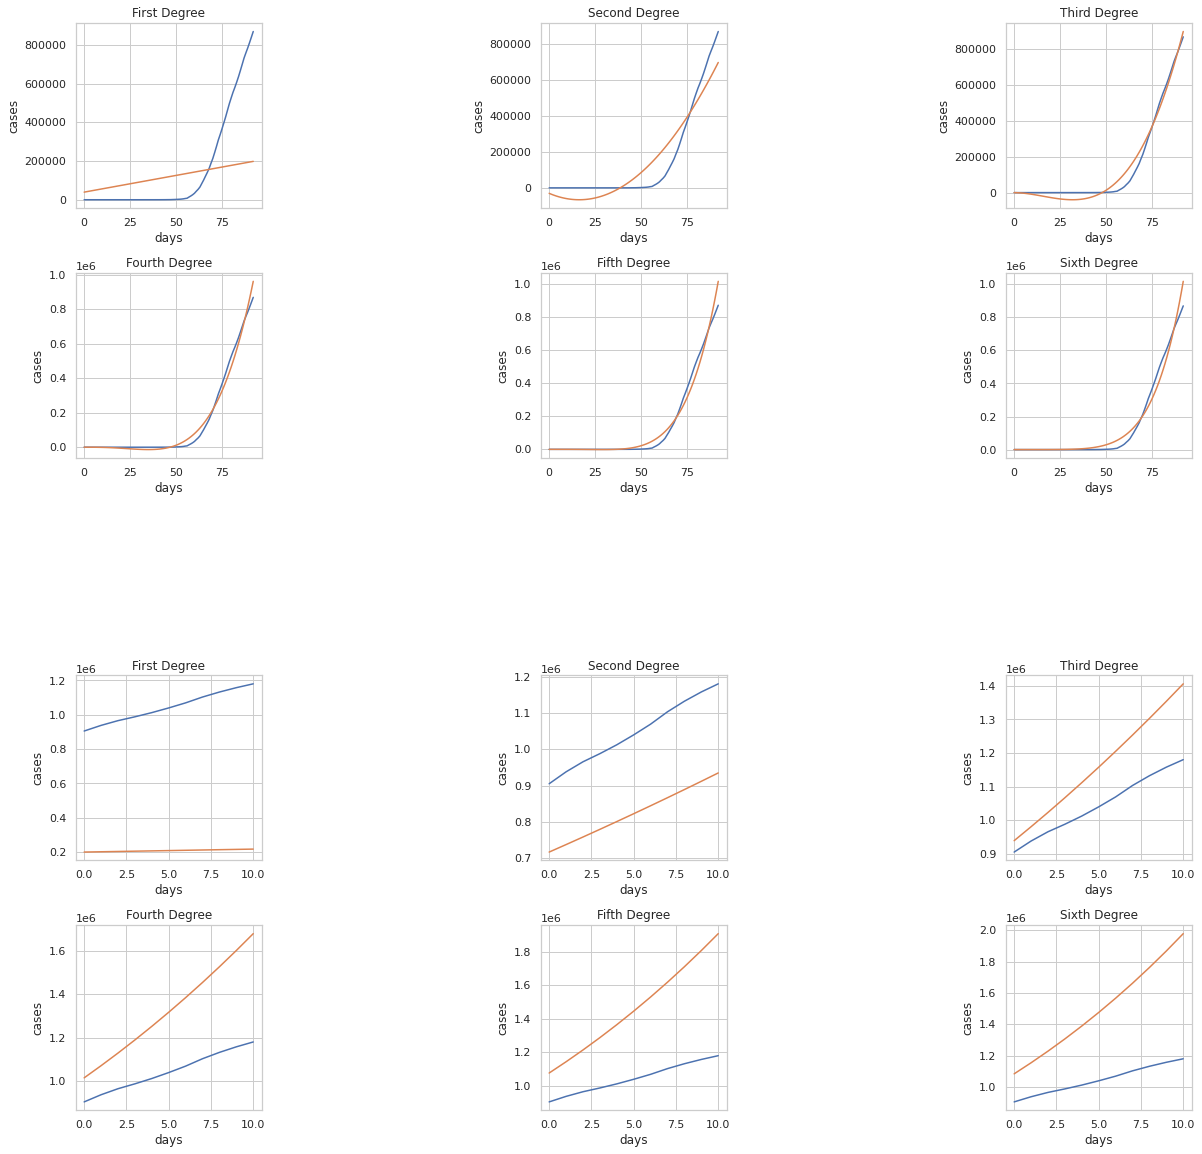

In [44]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US)
ax.plot(Huber_confirmed_1.predict(x_train_US_transformed_1))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US)
ax.plot(Huber_confirmed_2.predict(x_train_US_transformed_2))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US)
ax.plot(Huber_confirmed_3.predict(x_train_US_transformed_3))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US)
ax.plot(Huber_confirmed_4.predict(x_train_US_transformed_4))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US)
ax.plot(Huber_confirmed_5.predict(x_train_US_transformed_5))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US)
ax.plot(Huber_confirmed_6.predict(x_train_US_transformed_6))
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = Huber_confirmed_1.predict(x_test_US_transformed_1)
H_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US)
ax.plot(y_pred_US_1)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = Huber_confirmed_2.predict(x_test_US_transformed_2)
H_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US)
ax.plot(y_pred_US_2)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = Huber_confirmed_3.predict(x_test_US_transformed_3)
H_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US)
ax.plot(y_pred_US_3)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = Huber_confirmed_4.predict(x_test_US_transformed_4)
H_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US)
ax.plot(y_pred_US_4)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = Huber_confirmed_5.predict(x_test_US_transformed_5)
H_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US)
ax.plot(y_pred_US_5)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = Huber_confirmed_6.predict(x_test_US_transformed_6)
H_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US)
ax.plot(y_pred_US_6)
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',H_rmse1,'\n',H_rmse2,'\n',H_rmse3,'\n',H_rmse4,'\n',H_rmse5,'\n',H_rmse6)

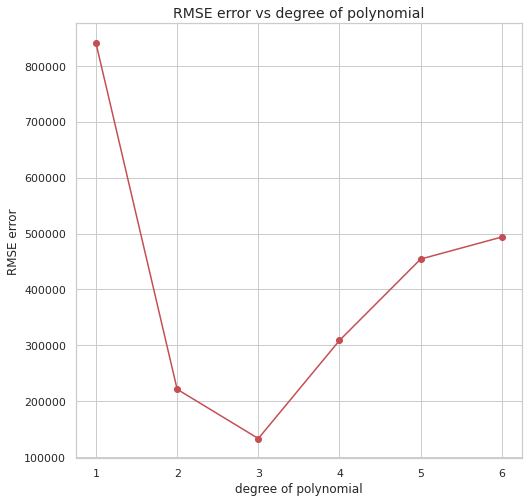

In [45]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[H_rmse1,H_rmse2,H_rmse3,H_rmse4,H_rmse5,H_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

###Compare regressors

 After choosing the best degree for each regressor, we compare those regressors in order to yield a regressor that can fit the dataset most

[70340.48454050477,
 72416.9085857246,
 150789.9199859319,
 196144.70358875958,
 174099.4982492406,
 133372.95754406782]

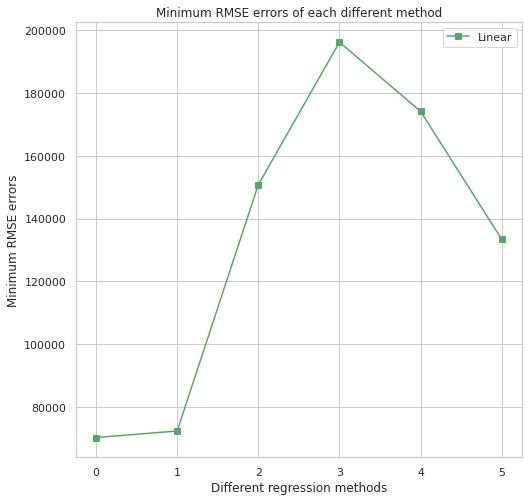

In [46]:
LR_min = sorted([rmse1,rmse2,rmse3,rmse4,rmse5,rmse6])[0]
Lasso_min = sorted([L_rmse1,L_rmse2,L_rmse3,L_rmse4,L_rmse5,L_rmse6])[0]
Ridge_min = sorted([R_rmse1,R_rmse2,R_rmse3,R_rmse4,R_rmse5,R_rmse6])[0]
Elastic_min = sorted([E_rmse1,E_rmse2,E_rmse3,E_rmse4,E_rmse5,E_rmse6])[0]
Bayesian_Ridge_min = sorted([BR_rmse1,BR_rmse2,BR_rmse3,BR_rmse4,BR_rmse5,BR_rmse6])[0]
Huber_min = sorted([H_rmse1,H_rmse2,H_rmse3,H_rmse4,H_rmse5,H_rmse6])[0]

fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.plot(range(6),[LR_min,Lasso_min,Ridge_min,Elastic_min,Bayesian_Ridge_min,Huber_min],'gs-')
axes.set_xlabel('Different regression methods')
axes.set_ylabel('Minimum RMSE errors')
axes.set_title('Minimum RMSE errors of each different method')
axes.legend(['Linear','Lasso','Ridge','Elastic','Bayesian Ridge','Huber'])
fig.show()
[LR_min,Lasso_min,Ridge_min,Elastic_min,Bayesian_Ridge_min,Huber_min]

Use Linear Regression of Degree 2 to predict the data in the coming 10 days

In [0]:
forecast_x_US = np.linspace(x_test_US[-1]+1,x_test_US[-1]+10,10)

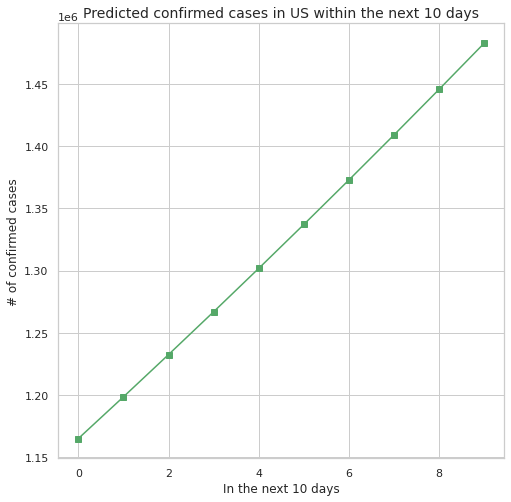

In [52]:
poly_forecast = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed = poly_forecast.fit_transform(x_train_US)
forecast_x_US_transformed = poly_forecast.fit_transform(forecast_x_US)


model2 = LinearRegression(normalize=False).fit(x_train_US_transformed_2,y_train_US)

# Use the estimator to do the prediction
forecast_y = model2.predict(forecast_x_US_transformed)

# Plot predicted values vs time 
fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.plot(range(len(forecast_y)),forecast_y,'gs-')
axes.set_xlabel('In the next 10 days')
axes.set_ylabel('# of confirmed cases')
axes.set_title('Predicted confirmed cases in US within the next 10 days',fontdict={'fontsize':14})
fig.show()

**Note: The best regressor may change as time evolves. Therefore, the regressor used for prediction as above should be chosen manually as time evolves.**

##Part III - Explore architectures of Convolutional Neural Networks to classify pneumonia Chest X-rays images

Note: Since the publicly released Chest X-rays images for COVID-19 are not enough to train. We use pneumonia Chest X-rays to train the CNNs. The trained CNNs could be directly used for classifying COVID-19 Chest X-rays images once the public dataset is large enough to be trained, but probably with minor changes in the image pre-preocessing part.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader as gdd
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
from tqdm import tqdm

In [50]:
# Use GPU
device = torch.device("cuda:0")
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [53]:
# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT,force_remount=True)


# create folder to write data to
CIS545_Final = os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_Liang')
os.makedirs(CIS545_Final, exist_ok=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#download images
gdd.download_file_from_google_drive(file_id='1zyoa2wQELSp3ho9Hyy-8FPea0Ttn_YK3',
                                    dest_path='/content/gdrive/My Drive/CIS545_Liang/data.zip')

In [55]:
!unzip "/content/gdrive/My Drive/CIS545_Liang/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._VIRUS-9624424-0003.jpeg  
  inflating: chest_xray/images/PNEUMONIA/BACTERIA-5378466-0001.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA-5378466-0001.jpeg  
  inflating: chest_xray/images/PNEUMONIA/BACTERIA-4371619-0002.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA-4371619-0002.jpeg  
  inflating: chest_xray/images/PNEUMONIA/VIRUS-7704214-0002.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._VIRUS-7704214-0002.jpeg  
  inflating: chest_xray/images/PNEUMONIA/VIRUS-292296-0002.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._VIRUS-292296-0002.jpeg  
  inflating: chest_xray/images/PNEUMONIA/BACTERIA-5150733-0013.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA-5150733-0013.jpeg  
  inflating: chest_xray/images/PNEUMONIA/BACTERIA-7942103-0002.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA

###Image preprocessing

In [0]:
size_N_x=[]
size_N_y=[]
size_P_x=[]
size_P_y=[]
normal=[]
pneumonia=[]
for path in tqdm(os.listdir('/content/chest_xray/images/NORMAL')):
  img_path = os.path.join('/content/chest_xray/images/NORMAL',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    shape = arr.shape
    size_N_x.append(shape[0])
    size_N_y.append(shape[1])
    label = np.eye(2)[0]
    arr = cv2.resize(arr,(300,300))
    arr = arr/255
    normal.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path)

for path in tqdm(os.listdir('/content/chest_xray/images/PNEUMONIA')):
  img_path = os.path.join('/content/chest_xray/images/PNEUMONIA',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    shape = arr.shape
    size_P_x.append(shape[0])
    size_P_y.append(shape[1])
    label = np.eye(2)[1]
    arr = cv2.resize(arr,(300,300))
    arr = arr/255
    pneumonia.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path) 


In [0]:
dataset=[]
index = np.random.choice(len(pneumonia),len(normal),replace=False)
for tup in normal:
  dataset.append(tup)
for i in index:
  dataset.append(pneumonia[i])

np.random.shuffle(dataset)
length = len(dataset)
train = dataset[:int(0.8*length)]
test = dataset[int(0.8*length):]

In [0]:
train = torch.utils.data.DataLoader(train,batch_size=128)
test = torch.utils.data.DataLoader(test,batch_size=9999)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.size = 64
        self.conv1 = nn.Conv2d(in_channels=1,out_channels = 4,kernel_size=3,stride = 3,padding=10) #300*300
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=8,kernel_size=4,stride =3,padding=10)
        self.conv3 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride =3,padding=10)
        self.conv4 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride =2,padding=10)
        self.conv5 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride =1)
        self.fc1 = nn.Linear(self.size,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,2)
    def convs(self,x):
        #(-1,1,300,300):  128*1*300*300
        x = F.max_pool2d(F.relu(self.conv1(x)),(5,5)) # 43*43


        x = F.max_pool2d(F.relu(self.conv2(x)),(5,5)) #10*10


        x = F.max_pool2d(F.relu(self.conv3(x)),(5,5)) # 3*3


        x = F.max_pool2d(F.relu(self.conv4(x)),(2,2)) # 5*5


        x = F.max_pool2d(F.relu(self.conv5(x)),(2,2)) # 1*1



        return x

    def forward(self,x,flag):
        # 128*64*1*1
        x = self.convs(x)
        #flatten the data
        if flag == True:
          x = x.view(-1,64) #128*64
        else:
          x = x.view(1,self.size) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1) # 128*2
        return x

### TRAIN

In [0]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss = nn.MSELoss()
epoch_loss_lst=[]
epochs =300
for epoch in tqdm(range(epochs)):
  for image,label in train:
    net.zero_grad()
    image = image.view(-1,1,300,300).type(torch.FloatTensor)
    label = label.type(torch.FloatTensor)
    image = image.to(device)
    label = label.to(device)
    output = net.forward(image,flag=True)
    batch_loss = loss(output,label)
    batch_loss.backward()
    optimizer.step()
  epoch_loss_lst.append(batch_loss)
  if epoch%20 == 0:
    print('Epoch:',epoch,'Loss:',batch_loss)

### Test the accuracy of the model with test dataset

In [0]:
TN = 0
TP = 0
FN = 0
FP = 0
accuracy = 0
case = 0
with torch.no_grad():
  for image, label in test:
    for i in range(len(image)):
      case+=1
      per_img = image[i].view(-1,1,300,300)
      per_img = per_img.type(torch.FloatTensor).to(device)
      output = net.forward(per_img,flag=False)
      pred = int(torch.argmax(output))
      true = int(torch.argmax(label[i]))
      if pred == 0:
        if true == 0:
          TN+=1
          accuracy+=1
        if true == 1:
          FN+=1
      if pred == 1:
        if true == 0:
          FP+=1
        if true == 1:
          TP+=1
          accuracy+=1
confusion_matrix = {'TN':TN,'FP':FP,'FN':FN,'TP':TP}
accuracy = accuracy/case

### Deeper classification

The model used before can only classify images as normal and pneumonia. Below this model can further classify images as normal, pneumonia - virus and pneumonia - bacteria.

Since the model is required to capture deeper characteristics in the images, thus we add image augmentation techniques in the image pre-preprocessing part.

In [0]:
normal=[]
pneumonia_v=[]
pneumonia_b=[]
for path in tqdm(os.listdir('/content/chest_xray/images/NORMAL')):
  img_path = os.path.join('/content/chest_xray/images/NORMAL',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    label = np.eye(3)[0]
    arr = cv2.resize(arr,(200,200))
    arr = arr/255
    normal.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path)

for path in tqdm(os.listdir('/content/chest_xray/images/PNEUMONIA')):
  img_path = os.path.join('/content/chest_xray/images/PNEUMONIA',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    if img_path.split('/')[-1].split('-')[0] == 'VIRUS':
      arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
      label = np.eye(3)[1]
      arr = cv2.resize(arr,(200,200))
      arr = arr/255      
      pneumonia_v.append((arr,label))

    if img_path.split('/')[-1].split('-')[0] == 'BACTERIA':
      arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
      label = np.eye(3)[2]
      arr = cv2.resize(arr,(200,200))
      arr = arr/255
      pneumonia_b.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path) 


In [0]:
dataset=[]
index_n = np.random.choice(len(normal),len(pneumonia_v),replace=False)
index_b = np.random.choice(len(pneumonia_b),len(pneumonia_v),replace=False)
count = 0
for tup in pneumonia_v:
  count+=1
  dataset.append(tup)
  new_arr = cv2.rotate(tup[0],cv2.ROTATE_180)
  new_tup = (new_arr,np.eye(3)[1])
  dataset.append(new_tup)
  if count%15 == 0:
    flip_tup = (np.fliplr(tup[0]).copy(),np.eye(3)[1])
    dataset.append(flip_tup)

count = 0
for i in index_n:
  count+=1
  dataset.append(normal[i])
  new_arr = cv2.rotate(normal[i][0],cv2.ROTATE_90_CLOCKWISE)
  new_tup = (new_arr,np.eye(3)[0])
  dataset.append(new_tup)
  if count%15 == 0:
    flip_tup = (np.fliplr(normal[i][0]).copy(),np.eye(3)[0])
    dataset.append(flip_tup)

count = 0
for i in index_b:
  count += 1
  dataset.append(pneumonia_b[i])
  new_arr = cv2.rotate(pneumonia_b[i][0],cv2.ROTATE_90_COUNTERCLOCKWISE)
  new_tup = (new_arr,np.eye(3)[2])
  dataset.append(new_tup)
  if count%15 == 0:
    flip_tup = (np.fliplr(pneumonia_b[i][0]).copy(),np.eye(3)[2])
    dataset.append(flip_tup)

np.random.shuffle(dataset)
length = len(dataset)
train = dataset[:int(0.8*length)]
test = dataset[int(0.8*length):]

In [0]:
train = torch.utils.data.DataLoader(train,batch_size=128)
test = torch.utils.data.DataLoader(test,batch_size=9999)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.size = 64
        self.conv1 = nn.Conv2d(in_channels=1,out_channels = 4,kernel_size=3,stride = 3,padding=10) #300*300
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=8,kernel_size=4,stride =3,padding=10)
        self.conv3 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride =3,padding=10)
        self.conv4 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride =2,padding=10)
        self.conv5 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride =1)
        self.fc1 = nn.Linear(self.size,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,3)
    def convs(self,x):
        #(-1,1,300,300):  128*1*300*300
        x = F.max_pool2d(F.relu(self.conv1(x)),(5,5)) # 43*43


        x = F.max_pool2d(F.relu(self.conv2(x)),(5,5)) #10*10


        x = F.max_pool2d(F.relu(self.conv3(x)),(5,5)) # 3*3


        x = F.max_pool2d(F.relu(self.conv4(x)),(2,2)) # 5*5


        x = F.max_pool2d(F.relu(self.conv5(x)),(2,2)) # 1*1



        return x

    def forward(self,x,flag):
        # 128*64*1*1
        x = self.convs(x)
        #flatten the data
        if flag == True:
          x = x.view(-1,64) #128*64
        else:
          x = x.view(1,self.size) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1) # 128*3
        return x

####TRAIN

In [0]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss = nn.MSELoss()
epoch_loss_lst=[]
epochs =2000
for epoch in tqdm(range(epochs)):
  for image,label in train:
    net.zero_grad()
    image = image.view(-1,1,200,200).type(torch.FloatTensor)
    label = label.type(torch.FloatTensor)
    image = image.to(device)
    label = label.to(device)
    output = net.forward(image,flag=True)
    batch_loss = loss(output,label)
    batch_loss.backward()
    optimizer.step()
  epoch_loss_lst.append(batch_loss)
  if epoch%20 == 0:
    print('Epoch:',epoch,'Loss:',batch_loss)

####TEST

In [0]:
accuracy = 0
case = 0
with torch.no_grad():
  for image, label in test:
    for i in range(len(image)):
      case+=1
      per_img = image[i].view(-1,1,200,200)
      per_img = per_img.type(torch.FloatTensor).to(device)
      output = net.forward(per_img,flag=False)
      pred = int(torch.argmax(output))
      true = int(torch.argmax(label[i]))
      if pred == 0 and true == 0:
        accuracy+=1
      if pred == 1 and true == 1:
        accuracy+=1
      if pred == 2 and true == 2:
        accuracy+=1       

accuracy = accuracy/case

In [0]:
accuracy